# Loan Prediction

Trying to predict the eligibility of Customer for a home loan.


In [107]:
import pandas as pd
import numpy as np
from   sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
train = pd.read_csv('../Data/loan_train.csv')
train.drop(columns = ['Loan_ID'], inplace = True, axis = 1)
data = train

test = pd.read_csv('../Data/loan_test.csv')
test.drop(columns = ['Loan_ID'], inplace = True, axis = 1)




In [109]:
def get_transformed(data, test = False):
    # Gender Dummification
    sexohe = pd.get_dummies(data.Gender).astype(int)
    sexohe.drop(columns = 'Female', axis = 1, inplace = True)
    # Married Dummfication
    Marriedohe = pd.get_dummies(data.Married, prefix= 'Married').astype(int)
    #Marriedohe.columns = ['Married_No', 'Married_Yes']
    Marriedohe.drop(columns = 'Married_No', axis = 1, inplace = True)
    # Graduate Dummification
    Gradohe = pd.get_dummies(data.Education).astype(int)
    Gradohe.drop(columns = 'Not Graduate', inplace = True, axis = 1)
    # Self Employed Dummification
    selfohe = pd.get_dummies(data.Self_Employed).astype(int)
    selfohe.drop(columns = 'No', inplace = True, axis = 1)
    selfohe.columns = ['Self_Employed=Yes']
    # Property_Area Dummification
    propohe = pd.get_dummies(data.Property_Area).astype(int)
    propohe.drop(columns=['Semiurban'], axis = 1, inplace=True)
    #dependents Dummification
    depohe = pd.get_dummies(data.Dependents, prefix='Dependents').astype(int)
    depohe.drop(columns=['Dependents_3+'], inplace=True, axis = 1)
    # Loan Approved
    if test == False:
        loanohe = pd.get_dummies(data.Loan_Status, prefix = "Loan_Status")
        loanohe.drop(columns = ['Loan_Status_N'], inplace = True, axis = 1)
        loanohe.columns = ['Loan Status']
        data1 = pd.concat([data, sexohe, Marriedohe, Gradohe, selfohe, propohe, depohe, loanohe], axis = 1)
        data1.drop(columns = ['Gender', 'Married','Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'], axis = 1, inplace = True)
    else:
        data1 = pd.concat([data, sexohe, Marriedohe, Gradohe, selfohe, propohe, depohe], axis = 1)
        data1.drop(columns = ['Gender', 'Married','Dependents', 'Education', 'Self_Employed', 'Property_Area'], axis = 1, inplace = True)

    data1.LoanAmount = data1.LoanAmount.fillna(data1.LoanAmount.median())
    data1.Loan_Amount_Term = data1.Loan_Amount_Term.fillna(data1.Loan_Amount_Term.median())
    data1.Credit_History = data1.Credit_History.fillna(data1.Credit_History.median())
    
    return data1


In [110]:
data1 = get_transformed(data)
testdata = get_transformed(test, True)

In [111]:
corrplot = pd.concat([data1], axis = 1).corr()

<AxesSubplot:>

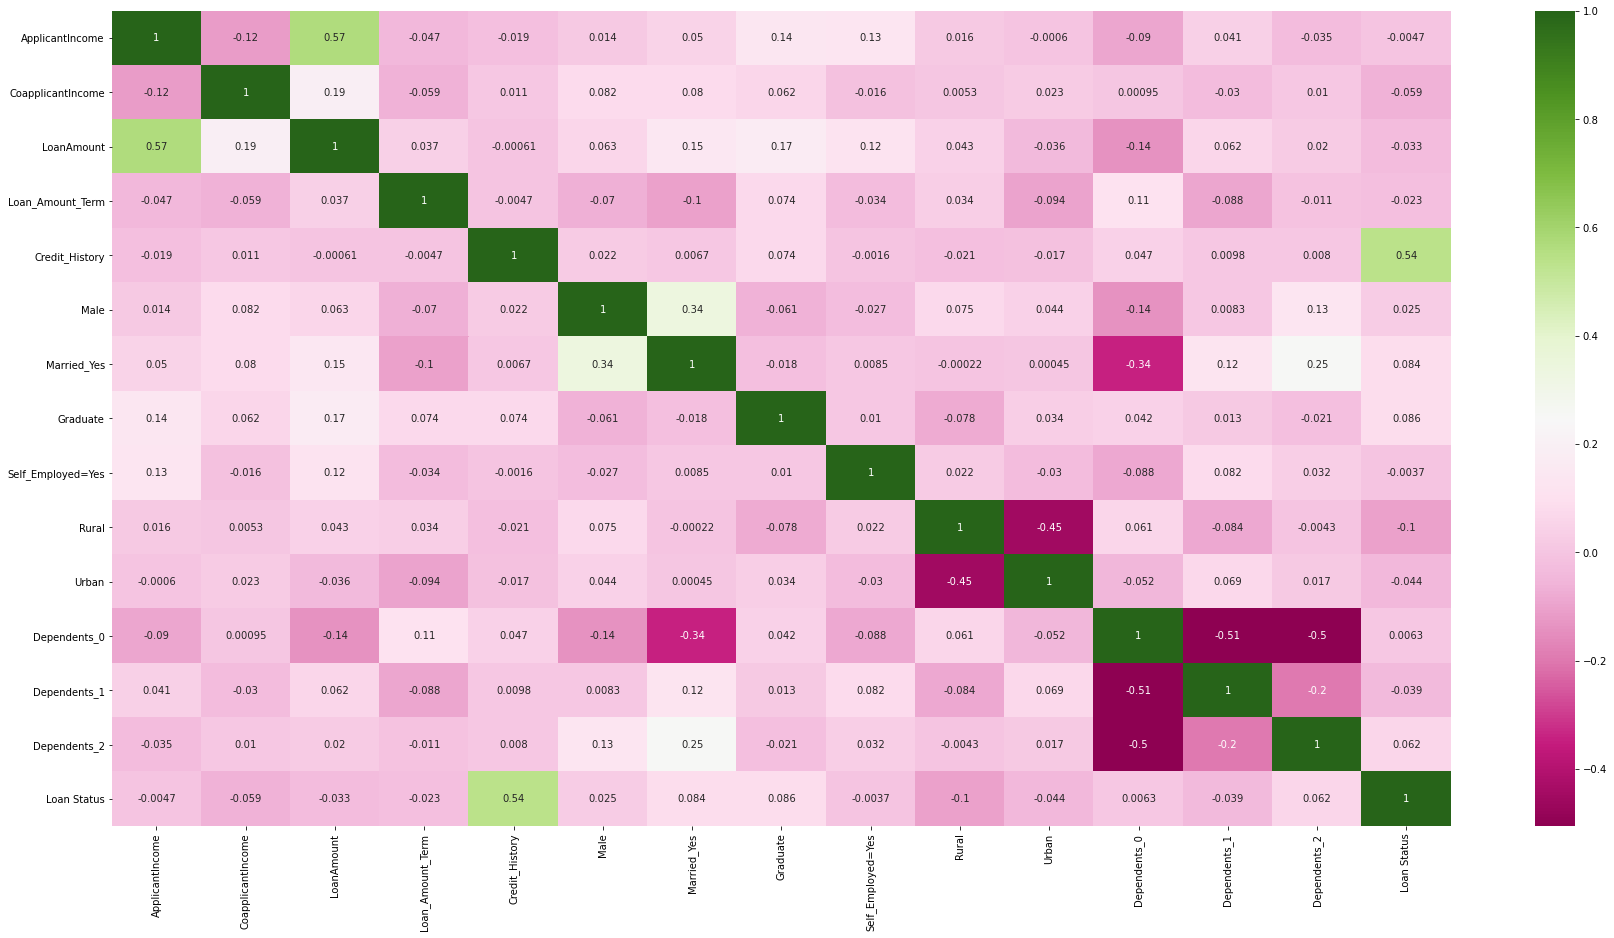

In [112]:
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(corrplot, xticklabels=corrplot.columns, yticklabels=corrplot.columns, annot=True, cmap="PiYG", ax = ax)

In [113]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [114]:
data1.columns
Xtrain.columns == Xtest.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [115]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data1.iloc[:,0:14], data1.iloc[:,14], test_size = 0.3)

In [116]:
cross_val_score(LogisticRegression(), Xtrain, Ytrain, cv = 10, scoring = 'accuracy').mean()

0.7925249169435216

In [117]:
cross_val_score(MLPClassifier(hidden_layer_sizes= (4, 4), activation= 'logistic', alpha=0.1, solver='sgd', learning_rate = 'invscaling', power_t = 0.05, max_iter = 500, learning_rate_init = 0.01), Xtrain, Ytrain, cv = 5, scoring = 'accuracy').mean()

0.6876607387140903

In [118]:
#cross_val_score(SVC(C=2), Xtrain, Ytrain, cv = 4, scoring = 'accuracy').mean()

In [129]:
cross_val_score(RandomForestClassifier(n_estimators=35, max_depth= 4), data1.iloc[:,0:14], data1.iloc[:,14], cv = 10, scoring = 'accuracy').mean()

0.8095716552088842

# Random Forest

In [120]:
mlp = MLPClassifier(hidden_layer_sizes= (4), 
activation= 'logistic', 
alpha=0.001, 
#solver='sgd', 
#learning_rate = 'invscaling', 
#power_t = 0.05, 
max_iter = 500, 
learning_rate_init = 0.001)
model = mlp.fit(Xtrain, Ytrain)

In [121]:
result = model.predict(Xtest)

In [122]:
confusion_matrix(y_pred=result, y_true = Ytest)

array([[  0,  58],
       [  0, 127]])

In [123]:
# rf = RandomForestClassifier(n_estimators=35, max_depth=5, max_features=5)
# model = rf.fit(Xtrain, Ytrain)
# results = model.predict(get_transformed(test, True))

# Logistic Regression

In [134]:
lr = LogisticRegression()
model = lr.fit(data1.iloc[:,0:14], data1.iloc[:,14])
results = model.predict(get_transformed(test, True))


In [135]:
submission = pd.read_csv('../Data/loan_submission.csv')


In [136]:
submission['Loan_Status'] = results

In [137]:
submission['Loan_Status'] = submission.Loan_Status.astype(str)

In [138]:
submission['Loan_Status'] = np.where(submission['Loan_Status'].str.contains('1'),'Y', 'N')

In [139]:
submission.Loan_Status.value_counts()

Y    307
N     60
Name: Loan_Status, dtype: int64

In [140]:
submission.to_csv('../Data/Submission_Loan.csv', index= False)